In [29]:
# LOADING THE DATA

import pandas as pd
train=pd.read_csv("/content/DailyDelhiClimateTrain.csv")
test=pd.read_csv("/content/DailyDelhiClimateTest.csv")

In [30]:
train['date']=pd.to_datetime(train['date'])
test['date']=pd.to_datetime(test['date'])

In [31]:
print(train.head())

        date   meantemp   humidity  wind_speed  meanpressure
0 2013-01-01  10.000000  84.500000    0.000000   1015.666667
1 2013-01-02   7.400000  92.000000    2.980000   1017.800000
2 2013-01-03   7.166667  87.000000    4.633333   1018.666667
3 2013-01-04   8.666667  71.333333    1.233333   1017.166667
4 2013-01-05   6.000000  86.833333    3.700000   1016.500000


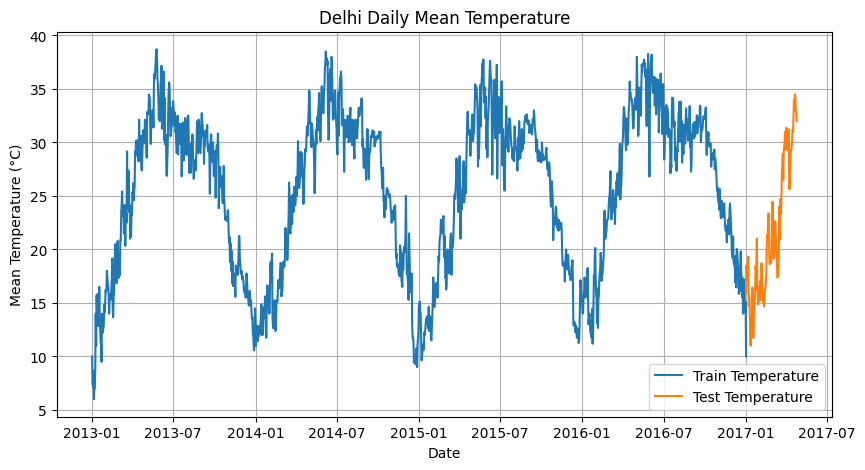

In [32]:
# plotting the temp vs time

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train['date'], train['meantemp'], label='Train Temperature')
plt.plot(test['date'], test['meantemp'], label='Test Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.title('Delhi Daily Mean Temperature')
plt.legend()
plt.grid()
plt.show()

In [35]:
# for forecast we will be using prophet
df_train = train.rename(columns={
    'date': 'ds',
    'meantemp': 'y'
})

extra_features = ['humidity', 'wind_speed', 'meanpressure']
! pip install prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5yv5ja36/jdmfjvc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5yv5ja36/5e8fq0d0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8248', 'data', 'file=/tmp/tmp5yv5ja36/jdmfjvc_.json', 'init=/tmp/tmp5yv5ja36/5e8fq0d0.json', 'output', 'file=/tmp/tmp5yv5ja36/prophet_modelin331jf6/prophet_model-20250716033141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:31:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:31:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


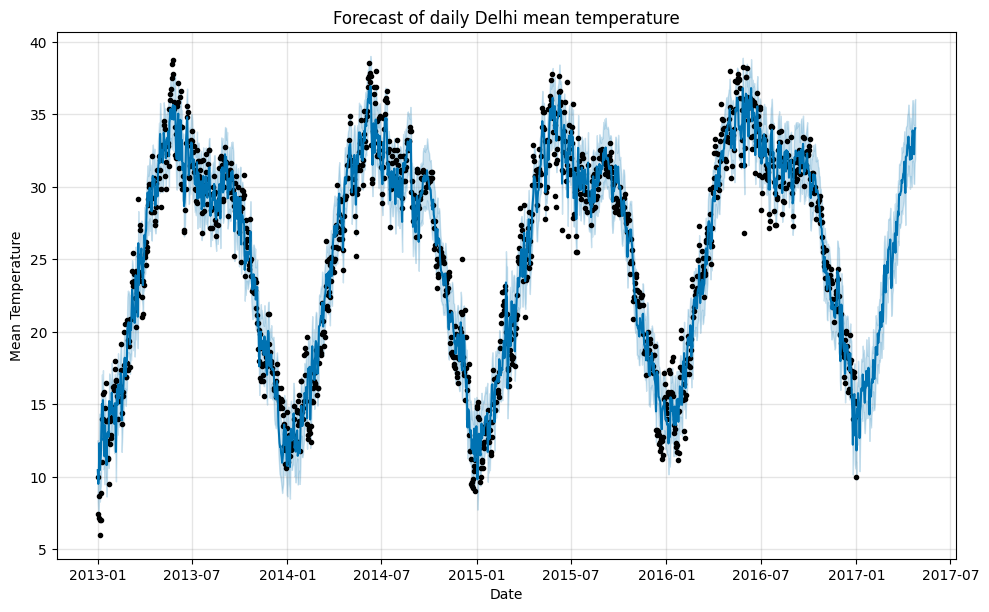

In [36]:
from prophet import Prophet
df_prophet=train[['date','meantemp']].rename(columns={'date':'ds', 'meantemp':'y'})

model=Prophet()
# Add extra regressors
for feature in extra_features:
    model.add_regressor(feature)

model.fit(df_train[['ds','y']+ extra_features])

# Combine train + test
df_all = pd.concat([train, test], axis=0)
df_all['ds'] = pd.to_datetime(df_all['date'])

# Final dataframe for future prediction
future = df_all[['ds'] + extra_features]

forecast=model.predict(future)

# Extract just the forecast for the test range

forecast_test = forecast.set_index('ds').loc[test['date'], 'yhat']
model.plot(forecast)
plt.title('Forecast of daily Delhi mean temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.show()



Mean Squared Error: 7.09
Mean Absolute Error: 2.19


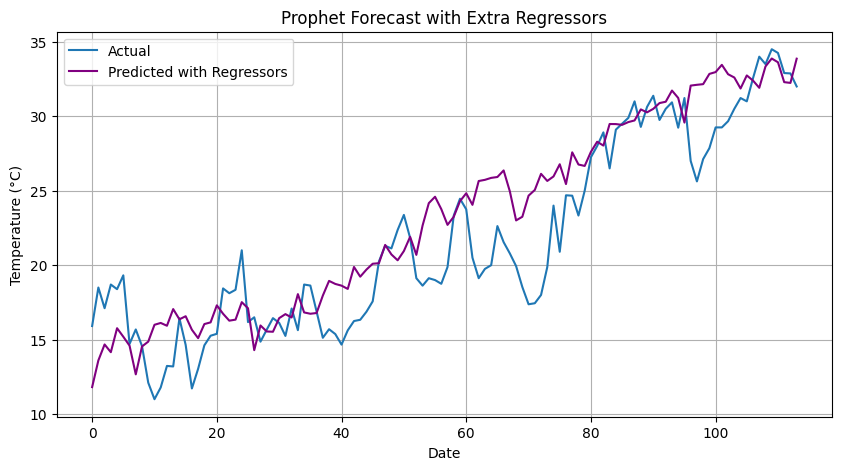

In [38]:
# evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(combined['meantemp'], combined['yhat'])
mae = mean_absolute_error(combined['meantemp'], combined['yhat'])

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
forecast_test = forecast_test[:len(test)]  # Trim to match


# Plot
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, forecast_test, label='Predicted with Regressors', color='purple')
plt.title('Prophet Forecast with Extra Regressors')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()